Alunos: João Martinho e Gustavo Guerreiro

# TRABALHO PARCIAL 01 [OPERADORES MORFOLÓGICOS]

Escolha e implemente um artigo que utilize as técnicas de Morfologia Matemática.  
Obs.: o artigo precisa ser validado com o professor.

## Breve Introdução
O objetivo desta implementação é a reprodução do trabalho feito por Carlos Eduardo Guerra pela Universidade Federal do Pará, neste trabalho foi utilizada Morfologia Matemática detectar padrões de baixa vegetação na região ao redor de Santarém, assim como dito nas palavras do autor:

> "The goal of this work is to detect some majors patterns related to forest absence. This detection is performed by means of morphological operators." (Guerra, 2007)

A diferença principal está nas ferramentas utilizadas, no caso do autor original foi usado MATLAB, nesta implementação se usa Python.

Inicialmente, importa-se as bibliotecas MatPlotLib, OpenCV, NumPy e Rasterio para realizar as operações necessárias.

In [125]:
%pip install matplotlib opencv-python numpy rasterio

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [126]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import rasterio

## Extração da imagem

Para essa aplicação foi escolhida uma foto semelhante à utilizada no artigo original, na região do município de Santarém no Pará. O artigo faz uso de fotos do sensor TM (Thematic Mapper) obtidas através de satélites, apesar do método utilizado para extração de imagens não ser explícito, considerando as referências utilizadas e a utilização da imagem em três bandas (3, 4 e 5), entendeu-se que o satélite utilizado foi o Landset 5, que separa as imagens em três bandas (faixas de comprimento de onda registradas pelo sensor). Nesse caso as faixas de bandas utilzadas pelos autores foram:

| Banda | Faixa Espectral $\mu\text{m}$ |
|----------|----------|
| 3 (Vermelho) | 0,63 – 0,69 |
| 4 (Infravermelho próximo) | 0,76 – 0,90 |
| 5 (Infravermelho médio) | 1,55 – 1,75 |

As imagens detectadas por esse satélite estão disponíveis no serviço EarthExplorer da USGS (United States Geological Survey), neste serviço foi feita uma busca pelo dataset Landsat 4-5 TM C2 L2, e uma foto da região metropolitana de Santarém com baixa densidade de nuvens (como o artigo sugere) foi escolhida. Para se assemelhar mais ao artigo original, as imagens adquiridas no EarthExplorer foram recortadas para abrangerem apenas a região de Santarém. Observando as imagens do artigo, percebe-se a ausência do rio na banda 3, apesar desta estar presente na original, por isso foi realizado um tratamento inicial usando o Google Earth Engine para usar a banda 5 como base para remover os corpos de água da banda 3 e ficar apenas com a terra, exatamente como no artigo. Segue o script utilizado no Google Earth Engine para fazer a retirada dos corpos de água usando o método MNDWI e exportar as imagens do satélite:

```javascript
// A variável "santarém" foi desenhada como um retângulo
// por meio da interface do Google Earth Explorer

// Adquirindo as fotos do LandSat 5 segundo as informções do EarthExplorer
var collection = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
  .filterBounds(santarem)
  .filterDate('2010-01-01', '2012-12-31')
  .filter(ee.Filter.lt('CLOUD_COVER', 5));

// Como o filtro foi específico a primeira imagem adquirida já está boa
var image = collection.first();


// Removendo os corpos de água com base nas bandas 2 e 5
var green = image.select('SR_B2');
// SWIR1 -> Short Wave Infrared 1
var swir1 = image.select('SR_B5');
// MNDWI -> Modified Normalized Difference Water Index
var mndwi = green.subtract(swir1).divide(green.add(swir1));
var waterMask = mndwi.gt(0);
var masked = image.updateMask(waterMask.not());

// Exportando as bandas dejedas (3 sem água, 4, 5 e a composição das três bandas juntas)
Export.image.toDrive({
  image: masked.select(['SR_B3']),
  description: 'Santarem3semagua',
  scale: 30,
  region: santarem,
  fileFormat: 'GeoTIFF'
});

Export.image.toDrive({
  image: image.select(['SR_B4']),
  description: 'Santarem4',
  scale: 30,
  region: santarem,
  fileFormat: 'GeoTIFF'
});

Export.image.toDrive({
  image: image.select(['SR_B5']),
  description: 'Santarem5',
  scale: 30,
  region: santarem,
  fileFormat: 'GeoTIFF'
});

Export.image.toDrive({
  image: image.select(['SR_B3', 'SR_B4', 'SR_B5']),
  description: 'Santarem345',
  scale: 30,
  region: santarem,
  fileFormat: 'GeoTIFF'
});

```

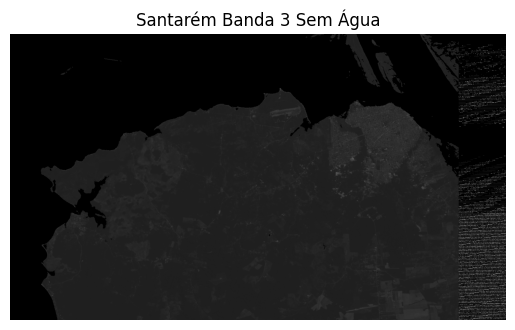

In [127]:
imagem = cv2.imread('Santarem3semagua.tif')
if len(imagem.shape) == 3:
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

plt.axis('off')
plt.title('Santarém Banda 3 Sem Água')
plt.imshow(imagem, 'gray')

## Detecção dos contornos com Morfologia Matemática

Tendo a imagem extraída e com seu brilho aumentado para facilitar a vizualização, aplica-se a binzarização para ficar apenas com os principais elementos da imagem.

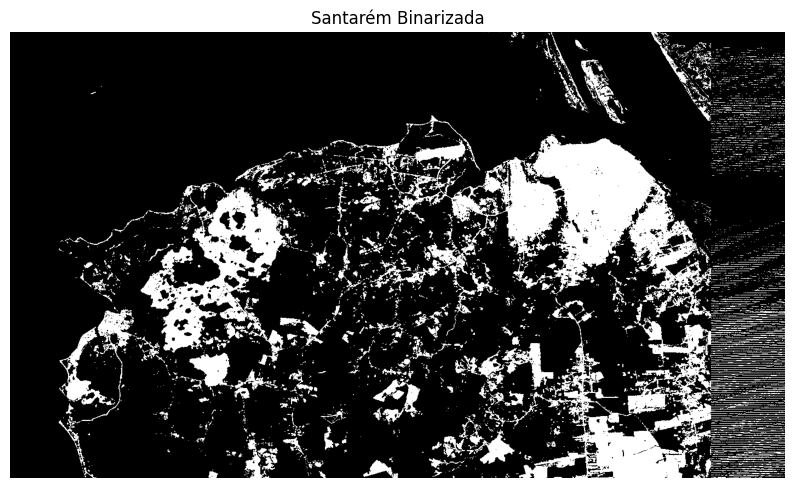

In [128]:
(T, binaria) = cv2.threshold(imagem, 34, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10, 10))
plt.title('Santarém Binarizada')
plt.axis("off")
plt.imshow(binaria, 'gray')

O artigo original usa um elemento estrurante (também chamado de *kernel*) de formato octogonal,  tal formato foi reproduzido em uma matriz 5x5.

In [129]:
kernel = np.array([
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0]
], dtype=np.uint8)

Em seguida se aplica o elemento estruturante à imagem binarizada. Deixando explícito as zonas com mais desmatamento, com destaque para a região metropolitana de Santarém, o aeroporto, a região da savana e o munícipio de Alter do Chão com suas praias, extamente como no artigo original.

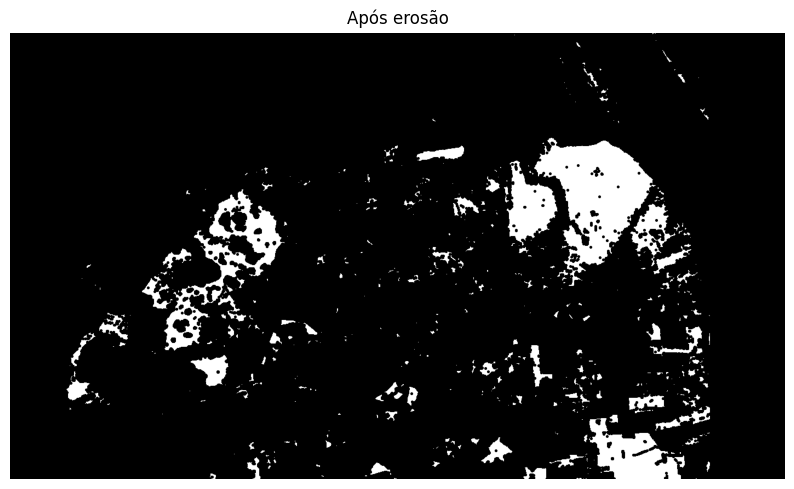

In [130]:
erodida = cv2.erode(binaria, kernel, iterations=1)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title("Após erosão")
plt.imshow(erodida, 'gray')

O artigo segue destacando as bordas obtidas com a erosão em vermelho, para isso foi utilizado a função findContours do OpenCV para encontrar os contornos das formas e então desenhá-los.

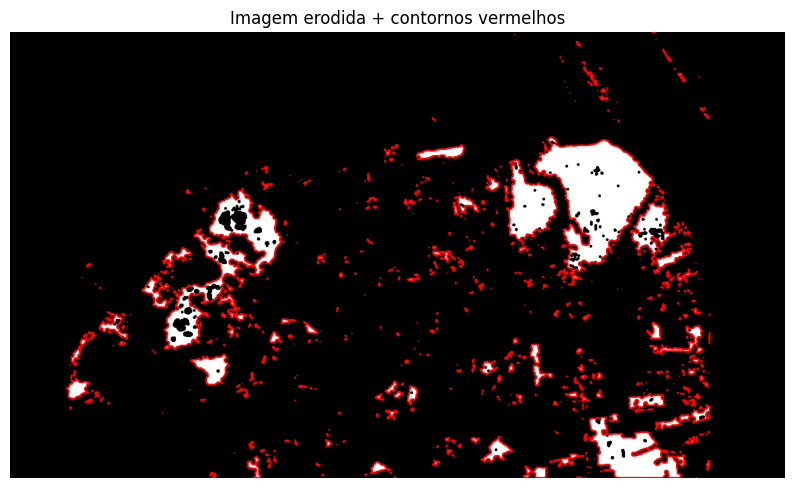

In [131]:
contornos, _ = cv2.findContours(erodida, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

imagem_colorida = cv2.cvtColor(erodida, cv2.COLOR_GRAY2BGR)
cv2.drawContours(imagem_colorida, contornos, -1, (0, 0, 255), thickness=2)

plt.figure(figsize=(10, 10))
plt.title("Imagem erodida + contornos vermelhos")
plt.axis("off")
plt.imshow(cv2.cvtColor(imagem_colorida, cv2.COLOR_BGR2RGB))

## Aplicação das bordas às imagens do satélite

Para fazer a visualização das bordas aplicadas às imagens do satélite, foi usado o arquivo com as 3 bandas juntas e utilizou-se Rasterio, com funções do NumPy e OpenCV para manipular o arquivo e mostrá-lo em cores, com a água em azul, as áreas com mais vegetação em verde e as áreas com menos vegetação, mais rosadas.

(np.float64(-0.5), np.float64(1414.5), np.float64(814.5), np.float64(-0.5))

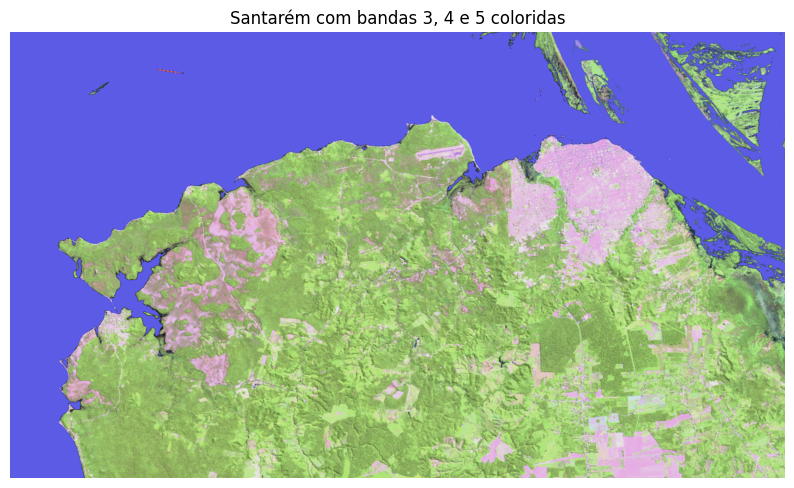

In [132]:
with rasterio.open("Santarem345.tif") as src:
    imagem_bandas = src.read()

imagem_bandas = np.transpose(imagem_bandas, (1, 2, 0))

def ajustar_contraste_percentil(banda, baixo=5, alto=95):
    p_baixo, p_alto = np.percentile(banda, (baixo, alto))
    banda = np.clip(banda, p_baixo, p_alto)
    banda = (banda - p_baixo) / (p_alto - p_baixo)
    return (banda * 255).astype(np.uint8)

b3 = ajustar_contraste_percentil(imagem_bandas[:, :, 0])
b4 = ajustar_contraste_percentil(imagem_bandas[:, :, 1])
b5 = ajustar_contraste_percentil(imagem_bandas[:, :, 2])

# Reordenar: R = B5, G = B4, B = B3
imagem_rgb = np.dstack((b5, b4, b3))

mask_agua = (b4 < 30) & (b5 < 30)

imagem_rgb_corrigida = imagem_rgb.copy()
imagem_rgb_corrigida[mask_agua] = [0, 0, 255]

hsv = cv2.cvtColor(imagem_rgb_corrigida, cv2.COLOR_RGB2HSV).astype(np.float32)
hsv[...,1] *= 0.6
hsv[...,2] *= 0.9
hsv = np.clip(hsv, 0, 255).astype(np.uint8)

imagem_rgb_suave = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

imagem_rgb = imagem_rgb_suave

plt.figure(figsize=(10,10))
plt.imshow(imagem_rgb)
plt.title("Santarém com bandas 3, 4 e 5 coloridas")
plt.axis("off")

Em seguida, colocou-se a máscara do resultado da erosão sobre a imagem colorida das bandas 3, 4 e 5 com o fim de destacar as regiões de maior desmatamento.

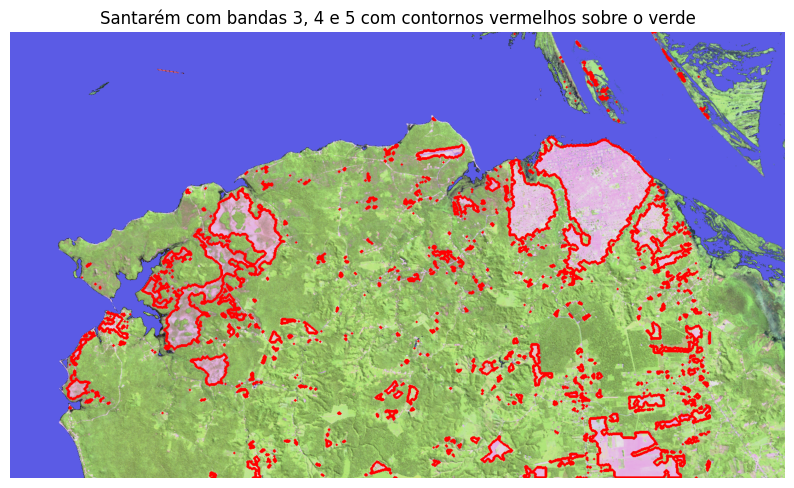

In [133]:
def colocar_mascara_com_bordas(terreno, bordas):
    alpha = 0.4
    return cv2.drawContours(terreno.copy(), bordas, -1, (255, 0, 0), thickness=3)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Santarém com bandas 3, 4 e 5 com contornos vermelhos sobre o verde')
plt.imshow(colocar_mascara_com_bordas(imagem_rgb, contornos))

Os resultados obtidos foram semelhantes aos do artigo, com foco para a área metropolitana, Alter do Chão, aeroporto, savana e praias.

Após esse resultado os autores do artigo aplicaram o mesmo elemento estruturante octogonal, mas na operação de dilatação, para tentar recuperar regiões inconsistentes. Segue a aplicação da metodologia, seguindo o mesmo método para destacar as regiões:

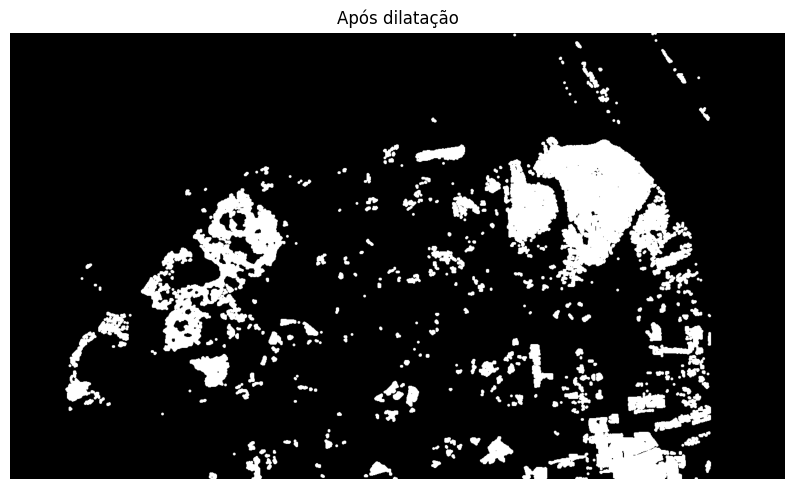

In [134]:
dilatada = cv2.dilate(erodida, kernel, iterations=1)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Após dilatação')
plt.imshow(dilatada, 'gray')

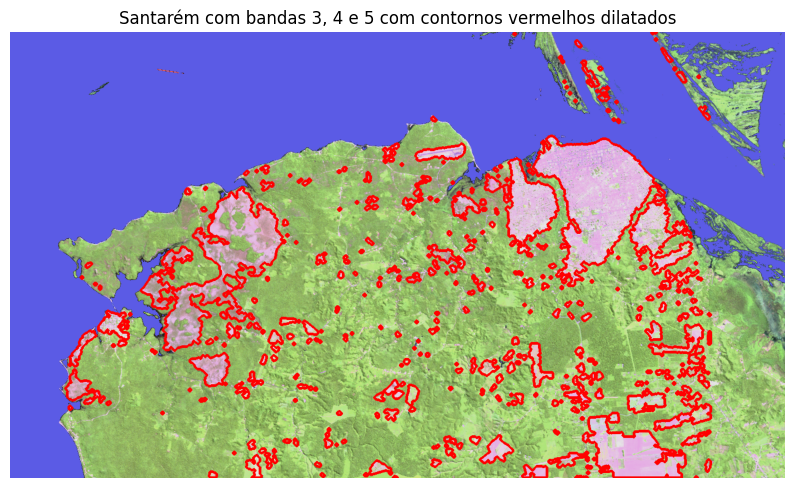

In [135]:
novas_bordas, _ = cv2.findContours(dilatada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Santarém com bandas 3, 4 e 5 com contornos vermelhos dilatados')
plt.imshow(colocar_mascara_com_bordas(imagem_rgb, novas_bordas))

## Conclusões

Após a implementação de todos os passos do artigo, foi possível reproduzir os seus resultados, chegando na mesma conclusão. As regiões com menor vegetação ficam destacadas com o contorno adquirido após a aplicação dos operadores, inclusive sendo possível notar as mesmas observações, os contornos obtidos após a aplicação dos da dilatação ficaram por muitas vezes separados e erodidos, principalmente na região da savana que ficou com trechos separados. Porém, após a dilatação, esses erros foram corrigidos, porém notou-se um aumento nas zonas verdes incluidas no contorno e o aumento de contornos inconsistentes.

Referências:

Google. **Google Earth Engine**. Disponível em: https://earthengine.google.com/. Acesso em: 8 set. 2025.

GUERRA, Carlos Eduardo. **Detecção de zonas de baixa cobertura vegetal em imagens de satélites através do uso de operadores da Morfologia Matemática**. SIMPÓSIO BRASILEIRO DE SENSORIAMENTO REMOTO, 13., 2007, Florianópolis.

U.S. GEOLOGICAL SURVEY. **EarthExplorer**. [S. l.]. Disponível em: https://earthexplorer.usgs.gov/. Acesso em: 6 set. 2025.

U.S. GEOLOGICAL SURVEY. **What are the band designations for Landsat satellites?**. [S. l.]. Disponível em: https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites. Acesso em: 6 set. 2025.

XU, Hanqiu. **Modification of normalised difference water index (NDWI) to enhance open water features in remotely sensed imagery**. International journal of remote sensing, v. 27, n. 14, p. 3025-3033, 2006.